# Training a NN with Urban Sound Challenge Data

**Background:**

In parallel to the actuall fall detection experiment, we'll train a neural network leveraging the urban challenge dataset in order to develop the necessary libraries to map wav files to features (either MFCC or spectogram) and baseline the performance of the different approaches)

## Libraries and File Locations

In [1]:
import matplotlib.pyplot as plt
from python_speech_features import mfcc, ssc, logfbank
import pandas as pd
import os
import numpy as np
import soundfile
from scipy import signal
import librosa
import matplotlib.pyplot as plt
import specdisplay

/home/romulo/github/python_virtual_envs/soundflux/lib/python3.6/site-packages/librosa/cache.py:36: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.cachedir is not None:
/home/romulo/github/python_virtual_envs/soundflux/lib/python3.6/site-packages/librosa/cache.py:36: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.cachedir is not None:
/home/romulo/github/python_virtual_envs/soundflux/lib/python3.6/site-packages/librosa/cache.py:36: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.cachedir is not None:
/home/romulo/github/python_virtual_envs/soundflux/lib/python3.6/

/home/romulo/github/python_virtual_envs/soundflux/lib/python3.6/site-packages/librosa/cache.py:36: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.cachedir is not None:
/home/romulo/github/python_virtual_envs/soundflux/lib/python3.6/site-packages/librosa/cache.py:36: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.cachedir is not None:
/home/romulo/github/python_virtual_envs/soundflux/lib/python3.6/site-packages/librosa/cache.py:36: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.cachedir is not None:
/home/romulo/github/python_virtual_envs/soundflux/lib/python3.6/

In [2]:
test_file_dir = "./tests/wav/"

## Load sample WAV File

Loading in the form of melspectrograms

**MFCCs and Spectrograms**

In [3]:
n_mels = 23

In [4]:
n_windows = 200

In [5]:
samples, sample_rate = soundfile.read(test_file_dir+"Bass-Drum-1.wav")

In [6]:
samples.shape

(55216, 2)

In [7]:
sample_channel_1 = samples[:,1]

In [8]:
hop_length = round(len(sample_channel_1)/n_windows)
hop_length

276

In [9]:
mel_spectrogram = librosa.feature.melspectrogram(y=sample_channel_1, 
                                                 sr=sample_rate,
                                                 n_fft=2048, 
                                                 hop_length=hop_length,
                                                 n_mels = n_mels,
                                                fmax = 8000)

In [10]:
mel_spectrogram.shape

(23, 201)

In [11]:
mel_spectrogram[:,:n_windows].shape

(23, 200)

Note that the below function (power_to_db) is equivalent to new: librosa.core.logamplitude

In [12]:
def extract_spectrogram(samples,sample_rate,n_windows=100,n_mels=23,n_fft=2048,fmax=8000):
    feature_set = []
    if samples.shape[1:]:
        channels = samples.shape[1:][0]
    else:
        channels = 1
        samples = np.expand_dims(samples, axis=1)
    for i in range(channels):
        sample_channel_x = samples[:,i]
        hop_length = round(len(sample_channel_x)/n_windows)
        mel_spectrogram = librosa.feature.melspectrogram(y=sample_channel_x, 
                                                     sr=sample_rate,
                                                     n_fft=n_fft, 
                                                     hop_length=hop_length,
                                                     n_mels = n_mels,
                                                    fmax = fmax)
        decibel_spec = librosa.logamplitude(mel_spectrogram,ref_power=np.max)
        feature_set.append(decibel_spec)
    feature_set = np.array(feature_set)
    feature_set = np.mean(feature_set,axis=0)[:,:n_windows]
    return feature_set

In [13]:
features = extract_spectrogram(samples,sample_rate)
features.shape

(23, 100)

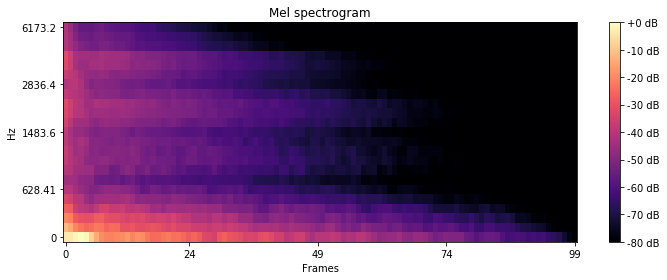

In [15]:
decibel_spec = extract_spectrogram(samples,sample_rate)
#decibel_spec = np.mean(features,axis=0)
plt.figure(figsize=(10, 4))
specdisplay.specshow(decibel_spec,
                          y_axis='mel', fmax=8000,
                          x_axis='frames',freq_fmt='Hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

## Training using Log Spectrogram

In [15]:
URBAN_SOUND_DIR = "/media/nvidia/ROMULO'S/urban_sound_challenge/"

In [16]:
train_df = pd.read_csv(URBAN_SOUND_DIR+'train.csv')
test_df = pd.read_csv(URBAN_SOUND_DIR+'test.csv')

In [17]:
def parse_features(row):
    # fun
    folder = 'Train'
    #ction to load files and extract features
    file_name = os.path.join(URBAN_SOUND_DIR,folder, str(row.ID) + '.wav')
   # handle exception to check if there isn't a file which is corrupted

    samples, sample_rate = soundfile.read(file_name)
    features = extract_spectrogram(samples,sample_rate)
    return pd.Series([features, row.Class])

In [18]:
def parse_features_test(row):
    # fun
    folder = 'Test'
    #ction to load files and extract features
    file_name = os.path.join(URBAN_SOUND_DIR,folder, str(row.ID) + '.wav')
   # handle exception to check if there isn't a file which is corrupted

    samples, sample_rate = soundfile.read(file_name)
    features = extract_spectrogram(samples,sample_rate)
    return pd.Series([features,row.ID])

In [19]:
temp = train_df.apply(parse_features, axis=1)
temp.columns = ['feature', 'label']

In [20]:
temp.to_json(URBAN_SOUND_DIR+"train_mel_spectrogram_transformed.json")

In [21]:
temp_test = test_df.apply(parse_features_test, axis=1)
temp_test.columns = ['feature','row_id']

In [22]:
temp_test.to_json(URBAN_SOUND_DIR+"test_mel_spectrogram_transformed.json")